In [1]:
%pylab inline
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import crop

In [3]:
import h5py 
import cv2
import os

In [4]:
with h5py.File('Galaxy10_DECals.h5', 'r') as File:
    images = np.array(File['images'])
    labels = np.array(File['ans'])

labels = labels.astype(np.float32)
images = images.astype(np.float32)

In [5]:
images.shape

(17736, 256, 256, 3)

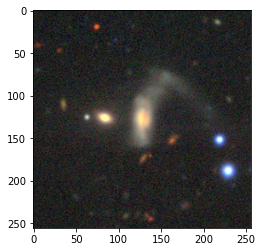

In [6]:
imshow(images[0].astype(np.uint8))

In [7]:
# TODO: write a long ass class to convert h5py output directly to dataloader

In [8]:
base_path = 'data'
os.makedirs(base_path, exist_ok=True)

In [9]:
for i, (image, label) in enumerate(zip(images, labels)):
    dir_path = os.path.join(base_path, str(label))
    os.makedirs(dir_path, exist_ok=True)
    cv2.imwrite(os.path.join(dir_path, str(i) + '.jpg'), image)

In [10]:
transform = transforms.Compose([
                                transforms.CenterCrop(60),
                                # transforms.Grayscale(),
                                # transforms.Lambda(lambda i : crop(i, 100, 100, 60, 60)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                                transforms.Resize((60, 60))
                               ])

In [11]:
imgset = torchvision.datasets.ImageFolder(base_path, transform=transform)

In [12]:
print(imgset[0][0].shape)
print(len(imgset))

torch.Size([3, 60, 60])
17736


In [13]:
trainset = torch.utils.data.Subset(imgset, range(14000))
testset = torch.utils.data.Subset(imgset, range(14000, 17736))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


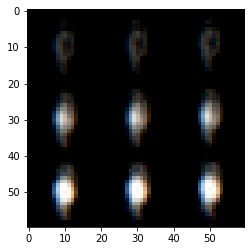

In [14]:
for i, (img, l) in enumerate(trainset):
    if i == 0:
        imshow(img.view(60, 60, 3))
        break

In [15]:
class GalaxyNet(nn.Module):
    
    def __init__(self):
        super(GalaxyNet, self).__init__()
        
        self.convs = nn.Sequential(
            nn.Conv2d(3, 64, 9, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 96, 5, stride=1, padding=2),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(96, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        
        self.lins = nn.Sequential(
            nn.Linear(4608, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
        )
        
        self.dropout = nn.Dropout(0.15)
        self.classifier = nn.Linear(256, 10)
        
        
    def forward(self, x):
        y = self.convs(x)
        # print(y.shape)
        y = self.dropout(y)
        # print(y.shape)
        y = y.reshape(y.size(0), -1)
        # print(y.shape)
        y = self.lins(y)
        # print(y.shape)
        y = self.classifier(y)

        return y
    
model = GalaxyNet()
model.to('cuda:0')

GalaxyNet(
  (convs): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lins): Sequential(
    (0): Linear(in_features=4608, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024,

In [16]:
optimizer = optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999), eps=1e-7, amsgrad=False) # 3e-4 0.0003

BATCH = 12
EPOCHS = 15

loss_fn = nn.CrossEntropyLoss()

In [17]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, num_workers=12, shuffle=True)

In [ ]:
losses = []
accuracies = []

model.train();

for epoch in trange(EPOCHS):
    running_loss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(trainloader):
        images, labels = data[0].to('cuda:0'), data[1].to('cuda:0')
        
        optimizer.zero_grad()

        out = model(images)
        
        loss = loss_fn(out, labels)

        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(out, 1)
        
        accuracy = (predicted == labels).float().mean()
        
        running_accuracy += accuracy.item()
        
        losses.append(loss.item())
        accuracies.append(accuracy.item())
        
    print('Epoch', epoch, 'Loss', running_loss / len(trainloader), 'Accuracy', running_accuracy / len(trainloader))

  0%|                                                                        | 0/15 [00:00<?, ?it/s]/usr/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /build/python-pytorch/src/pytorch-1.9.0-cuda/c10/core/TensorImpl.h:1153.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  7%|████▎                                                           | 1/15 [00:09<02:19,  9.95s/it]

Epoch 0 Loss 1.4102863577204887 Accuracy 0.46908027761086707


 13%|████████▌                                                       | 2/15 [00:16<01:42,  7.91s/it]

Epoch 1 Loss 0.9950371864471256 Accuracy 0.6479220415729687


In [ ]:
plt.plot(range(len(accuracies)), accuracies, 'g', label='Accuracy')
plt.plot(range(len(losses)), losses, 'b', label='Loss')
plt.title('Accuracy and Loss')
plt.show()

In [ ]:
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, num_workers=12, shuffle=True)

In [ ]:
total = 0
correct = 0

with torch.no_grad():
    model.eval();
    for data in tqdm(testloader):
        images, labels = data[0].to('cuda:0'), data[1].to('cuda:0')
        out = model(images)
        _, predicted = torch.max(out, 1)
        total += labels.size(0)
        correct = (labels == predicted).sum().item()

print('total', total)
print('correct', correct)
print('accuracy', round(correct / total, 3))